Originally I wanted to adapt a model for predicting NCAA basket ball outcomes to the NHL. The model is called [Bayesian Logistic Regression Markov Chain (LRMC)](https://www2.isye.gatech.edu/~jsokol/lrmc/) and it works by treating the difference in points between two teams in any game as a normally distributed random variable which depends on the inherent difference in skill between the two teams plus a home court advantage added to the home team. The home court advantage is assumed to be constant across all teams. Unfortunately, when I originally explored this idea I discovered that the difference in score between two teams in each game would not be a good fit for a normal distribution, and so I concluded there wouldn't be an easy way to fit the LRMC model to the NHL.

Refusing to give up on this project, I started looking at other ways to model HHL games, and thought about trying to model them in PYMC3. This thought lead me to a PYMC3 example called [A Hierarchical model for Rugby prediction](https://docs.pymc.io/notebooks/rugby_analytics.html) by Peadar Coyle. That work was inspired by [Daniel Weitzenfeld](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/), which in turn was based on a model first developed by [Gianluca Baio and Marta A. Blangiardo](http://www.statistica.it/gianluca/Research/BaioBlangiardo.pdf). With the help of the above examples and papers, I was able to figure out the preceding models and adapt them to the NHL. Due to NHL rules which force a winner of every game by first going to a five minute sudden death overtime, and then to a shootout, I have also extended the model to calculate a tie-breaker random variable to determine the ultimate winner.

In [1]:
# Import all of the libraries needed for this post
import requests
import json
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import theano
from itertools import combinations

/home/everett/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Before we can dive into creating the model, we need to get some data. The functions below use the requests and json libraries to extract the data we need from the official NHL statistics API. I have written the data to CSV file so that it is possible to perform the rest of the analysis without constantly retrieving the data over the Internet.

In [2]:
# A function that retrieves the game data from the NHL stats API
# for a selected date range.
def request_game_data(start_date, end_date):
    base_url = 'https://statsapi.web.nhl.com'
    path = '/api/v1/schedule?startDate='+start_date+\
            '&endDate='+end_date+'&expand=schedule.linescore'
    response = requests.get(base_url + path)
    return response.json()

# A function to extract the relevant data from the schedule
# and return it as a pandas dataframe
def extract_game_data(schedule):
    """Given full JSON records for games from the NHL API,
    returns a simplified list of just the data we need.
    """
    games = pd.DataFrame(columns=['date',
                                  'season',
                                  'game_type',
                                  'home_team',
                                  'home_team_reg_score',
                                  'home_team_fin_score',
                                  'away_team',
                                  'away_team_reg_score',
                                  'away_team_fin_score',
                                  'went_to_shoot_out'
                                  ])

    for date_obj in schedule['dates']:
        date = date_obj['date'];
        for game_obj in date_obj['games']:
            game_type = game_obj['gameType']
            season = game_obj['season']
            home_team_obj = game_obj['teams']['home']
            away_team_obj = game_obj['teams']['away']

            home_team = home_team_obj['team']['name']
            home_team_fin_score = home_team_obj['score']

            away_team = away_team_obj['team']['name']
            away_team_fin_score = away_team_obj['score']

            detailed_score_data = game_obj['linescore']
            period_data = detailed_score_data['periods']
            shootout_data = detailed_score_data['shootoutInfo']

            home_team_reg_score = 0
            away_team_reg_score = 0

            for period in period_data[0:3]:
                home_team_reg_score += period['home']['goals']
                away_team_reg_score += period['away']['goals']

            went_to_shoot_out = (shootout_data['home']['attempts'] != 0 or
                                 shootout_data['away']['attempts'] != 0)

            games = games.append({'date': date,
                                  'season': season,
                                  'game_type': game_type,
                                  'home_team': home_team,
                                  'home_team_reg_score': home_team_reg_score,
                                  'home_team_fin_score': home_team_fin_score,
                                  'away_team': away_team,
                                  'away_team_reg_score': away_team_reg_score,
                                  'away_team_fin_score': away_team_fin_score,
                                  'went_to_shoot_out': went_to_shoot_out
                                  }, ignore_index=True)

    return games

completed_game_data = request_game_data('2016-09-18', '2018-03-23')
completed_games = extract_game_data(completed_game_data)
completed_games.to_csv('completed_games.csv', index = False)

scheduled_game_data = request_game_data('2018-03-24', '2018-04-09')
scheduled_games = extract_game_data(scheduled_game_data)
scheduled_games.to_csv('scheduled_games.csv', index = False)

It is necessary to also decorate this data with integer labels for the home and away teams, as well as the team pairs. These labels serve as an array index for the random variables, and allow us to reference the correct random variables for each team or team pair in the PYMC3 model.

In [3]:
# Filter the data to just regular season games from the 2015-2016 and 
# 2016-2017 seasons 
completed_games = pd.read_csv('completed_games.csv')
completed_games = completed_games.loc[completed_games['game_type'] == 'R']

# Select the columns I need for this analysis
completed_games = completed_games[['home_team', 'away_team', 
                                   'home_team_reg_score', 
                                   'away_team_reg_score', 
                                   'home_team_fin_score', 
                                   'away_team_fin_score']]

# Extract the unique list of teams and assign an integer label to each one
teams = completed_games.home_team.unique()
teams = np.sort(teams)
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

# Create a unique list of each team combination and assign an integer label
# to each one. Also decide which team will be 'heads' in each pair.
all_teams_pair_combinations = combinations(teams['team'], 2)
team_pairs_dict = {}
team_pairs_heads_dict = {}
pair_index = 0
for pair in all_teams_pair_combinations:
    team_pairs_dict[(pair[0], pair[1])] = pair_index
    team_pairs_dict[(pair[1], pair[0])] = pair_index
    team_pairs_heads_dict[(pair[0], pair[1])] = pair[0]
    team_pairs_heads_dict[(pair[1], pair[0])] = pair[0]
    pair_index += 1
    
# Determine if the ultimate winner of the game was the heads team 
# (Bernoulli outcome = True) or the tails team (Bernoulli outcome = False)
def game_outcome_to_bernoulli_data(row):
    if row['home_team_fin_score'] > row['away_team_fin_score']:
        return row['home_team'] == team_pairs_heads_dict[(row['home_team'], row['away_team'])]
    return row['away_team'] == team_pairs_heads_dict[(row['home_team'], row['away_team'])]

# Modify the data to include team and pair integer labels
def add_team_data_labels(game_data):
    game_data = game_data.merge(teams, left_on='home_team', right_on='team', how='left')
    game_data = game_data.rename(columns={'i': 'i_home'}).drop('team', axis=1)
    game_data = game_data.merge(teams, left_on='away_team', right_on='team', how='left')
    game_data = game_data.rename(columns={'i': 'i_away'}).drop('team', axis=1)
    game_data['i_pair'] = game_data.apply(lambda row: team_pairs_dict[(row['home_team'], row['away_team'])], axis=1)  
    game_data['i_pair_winner'] = game_data.apply(game_outcome_to_bernoulli_data, axis=1)
    
    return game_data
    
completed_games = add_team_data_labels(completed_games)

Because the ultimate goal of this model is to make predictions about the outcomes for games that haven't been played yet we need to extract the data for the model into Theano shared variables as [described in the PYMC3 documentation](https://docs.pymc.io/advanced_theano.html). This will allow us to swap out the data for completed games with the scheduled games and then predict samples of game outcomes for those scheduled games too.

In [4]:
# Determine the total number of teams and team pairs for PYMC3
num_teams = len(completed_games.i_home.drop_duplicates())
num_team_pairs  = len(completed_games.i_pair.drop_duplicates())

# Create shaed theano variables that can be swapped out with
# scheduled games later.
home_team = theano.shared(completed_games.i_home.values)
away_team = theano.shared(completed_games.i_away.values)
team_pair = theano.shared(completed_games.i_pair.values)

# Create arrays of observations for our pymc3 model
observed_home_goals = completed_games.home_team_reg_score.values
observed_away_goals = completed_games.away_team_reg_score.values
observed_pair_outcomes = completed_games.i_pair_winner.values

Now we can fit the PYMC3 model. The model assumes that goals scored in regulation time by the home and the away team can be modeled as Poisson distributed random variables, which we treat as observed random variables since we can see the number of goals that were scored. We also assume that the distribution of these variables is dependent on some inherent features of the teams such as their defensive and offensive skill, as well as other phenomenon not specific to teams such as home ice advantage and a constant intercept term. All of these are unobserved random variables that we expect to determine the Poisson distributions for goals scored in each game. Additionally, the tie breaker is modeled as a Bernoulli observed random variable which I have opted to define using a Beta distribution as the unobserved random variable that determines the probability of a success. This Bernoulli random varable does not consider home ice advantage, as we determined in my last post that it does not play a major role in deciding the winner after a game makes it to overtime or a shootout.

In [5]:
with pm.Model() as model:
    # Global model parameters
    home = pm.Flat('home')
    sd_offence = pm.HalfStudentT('sd_offence', nu=3, sd=2.5)
    sd_defence = pm.HalfStudentT('sd_defence', nu=3, sd=2.5)
    intercept = pm.Flat('intercept')

    # Team-specific poisson model parameters
    offence_star = pm.Normal('offence_star', mu=0, sd=sd_offence, shape=num_teams)
    defence_star = pm.Normal('defence_star', mu=0, sd=sd_defence, shape=num_teams)
    offence = pm.Deterministic('offence', offence_star - tt.mean(offence_star))
    defence = pm.Deterministic('defence', defence_star - tt.mean(defence_star))
    home_theta = tt.exp(intercept + home + offence[home_team] - defence[away_team])
    away_theta = tt.exp(intercept + offence[away_team] - defence[home_team])

    # Team-pair bernoulli model parameters
    beta_a = np.array([1] * num_team_pairs)
    beta_b = np.array([1] * num_team_pairs)
    bernoulli_p = pm.Beta('binom_p', alpha=beta_a, beta=beta_b, shape=num_team_pairs)
    
    # Likelihood of observed data
    home_goals = pm.Poisson('home_goals', mu=home_theta, observed=observed_home_goals)
    away_goals = pm.Poisson('away_goals', mu=away_theta, observed=observed_away_goals)
    tie_breaker = pm.Bernoulli('tie_breaker', p=bernoulli_p[team_pair], observed=observed_pair_outcomes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [binom_p_logodds__, defence_star, offence_star, intercept, sd_defence_log__, sd_offence_log__, home]
100%|██████████| 3000/3000 [02:24<00:00, 20.75it/s]


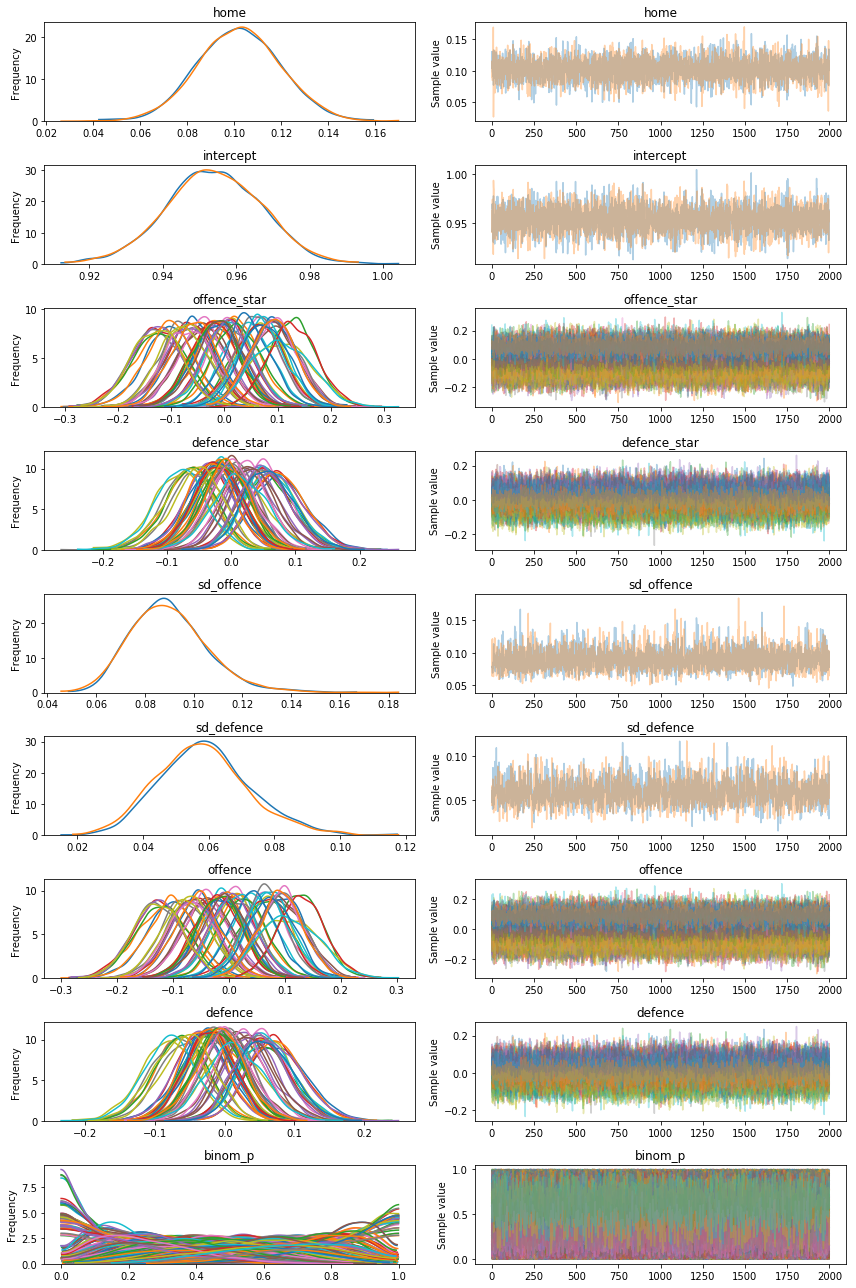

In [6]:
with model:
    trace = pm.sample(2000, tune=1000, cores=3)
    pm.traceplot(trace)

The trace plots make it appear as though the PYMC3 model has converged to the stationary distribution for each of the variables, suggesting that we do not need to adjust the burn-in period manually.

Next we can also look at the BFMI and Gelman-Rubin statistics:

In [7]:
bfmi = pm.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace).values())

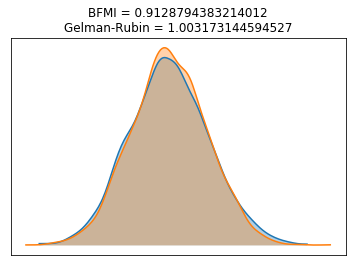

In [8]:
(pm.energyplot(trace, legend=False, figsize=(6, 4))
   .set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

The [BFMI statistic is well above the threshold of 0.2](https://docs.pymc.io/api/stats.html) that is typically suggested by the PYMC3 and Stan projects for indicating poor sampling. Furthermore, the Gelman-Rubin statistic is very close to 1, which further suggests that convergence on the stationary distribution has occurred.

Satisfied that the PYMC3 model hasn't failed miserably, let's look at the posterior distributions for some of the unobserved random variables like team offensive and defensive strengths:

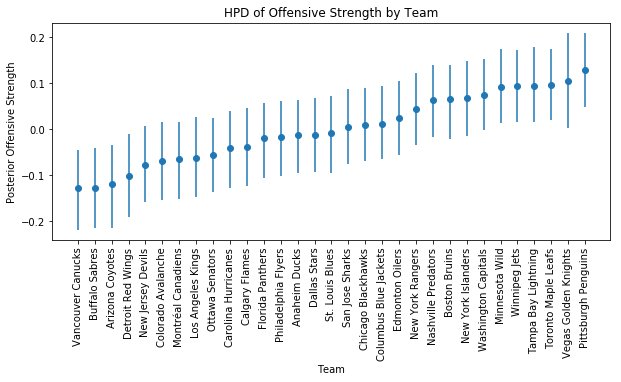

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
%matplotlib inline

df_hpd = pd.DataFrame(pm.stats.hpd(trace['offence']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['offence'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Offensive Strength by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Offensive Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=90)

The spread of offensive strengths looks pretty reasonable, and it seems to rank the teams well based on what little I know about their ability to score goals. Note that the Vegas Golden Knights have a slightly wider Highest Posterior Density (HPD) interval than the other teams. This makes sense since they have only started playing in the current recent season, and have far fewer games than the rest of the teams since we have included the complete 2016-2017 season in the data as well.

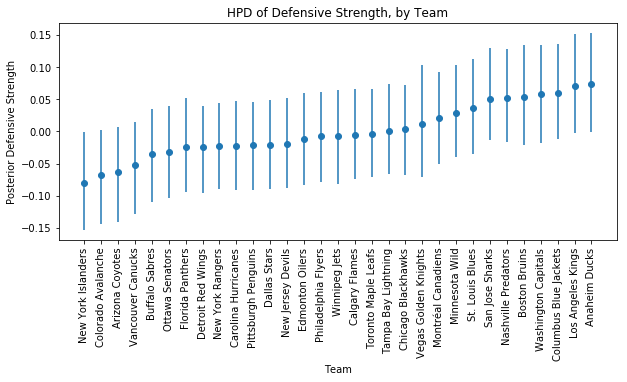

In [10]:
df_hpd = pd.DataFrame(pm.stats.hpd(trace['defence']),
                      columns=['hpd_low', 'hpd_high'],
                      index=teams.team.values)
df_median = pd.DataFrame(pm.stats.quantiles(trace['defence'])[50],
                         columns=['hpd_median'],
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_title('HPD of Defensive Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Defensive Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=90)

The spread of defensive strengths also appears reasonable, and once again Vegas has a slightly wider HPD as we would expect.

Now let's move on to the fun part and begin trying to predict outcomes for the remaining games.

In [11]:
scheduled_games = pd.read_csv('scheduled_games.csv')
scheduled_games = scheduled_games.loc[scheduled_games['game_type'] == 'R']

# Select the columns I need for this analysis
scheduled_games = scheduled_games[['home_team', 'away_team', 
                                   'home_team_reg_score', 'away_team_reg_score', 
                                   'home_team_fin_score', 'away_team_fin_score']]

scheduled_games = add_team_data_labels(scheduled_games)

# Create shared theano variables that can be swapped out with
# scheduled games later.
home_team.set_value(scheduled_games.i_home.values)
away_team.set_value(scheduled_games.i_away.values)
team_pair.set_value(scheduled_games.i_pair.values)

In [12]:
with model:
    post_pred = pm.sample_ppc(trace)

100%|██████████| 2000/2000 [00:02<00:00, 723.01it/s]


We can make sure that the shape of all our posterior predictions looks reasonable. There are 122 games left in the 2017-2018 Regular season, and for our posterior predictions there are 2000 samples for each game, times 122 games.

In [13]:
print(scheduled_games.shape)
print(post_pred['away_goals'].shape)
print(post_pred['home_goals'].shape)
print(post_pred['tie_breaker'].shape)

(122, 10)
(2000, 122)
(2000, 122)
(2000, 122)


Let's look at how these simulations play out. For simplicity I will first examine a single game; the Calgary Flames vs the San Jose Sharks in San Jose. I picked this game in particular since my father is a Flames fan, and this is the next game they will play. Let us start by looking at the predicted number of goals each team will score during regulation time:

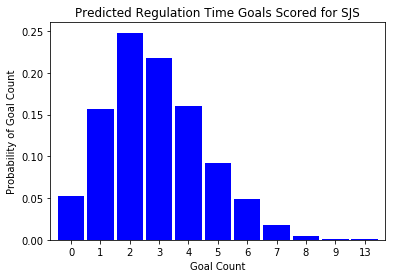

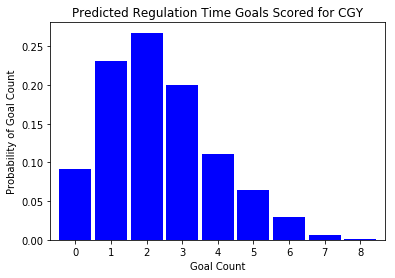

In [19]:
import matplotlib.pyplot as plt

def plot_posterior_goal_count(posterior_goals, team_name):
    fig = plt.figure()
    ax = fig.add_subplot()

    vc = pd.Series(posterior_goals).value_counts().sort_index()
    vc /= float(vc.sum())
    ax = vc.plot(kind='bar', width=0.9, color='b')

    ax.set_ylabel('Probability of Goal Count')
    ax.set_xlabel('Goal Count')
    ax.set_title('Predicted Regulation Time Goals Scored for {}'.format(team_name))
    
    fig = ax.get_figure()
    plt.xticks(rotation=0)
    plt.show()

plot_posterior_goal_count(post_pred['home_goals'][:,1], 'SJS')
plot_posterior_goal_count(post_pred['away_goals'][:,1], 'CGY')

San Jose appears to skew a bit higher in the predicted number of regulation tie goals. As a result, we should probably expect San Jose to be more likely to win this game. Let's see what the predicted probabilities are:

In [15]:
# Determine all the games in which the home and away teams win, lose, 
# or tie in regulation time
home_won_regulation = post_pred['home_goals'] > post_pred['away_goals']
away_won_regulation = post_pred['away_goals'] > post_pred['home_goals']
regulation_tie = post_pred['home_goals'] == post_pred['away_goals']

# Determine which team utimately wins in the event of a tie
home_won_tie_breaker = post_pred['tie_breaker'].copy()
away_won_tie_breaker = post_pred['tie_breaker'].copy()
home_team_is_heads = np.array([(home_team == team_pairs_heads_dict[(home_team, away_team)]) for 
                               home_team, away_team in 
                               zip(scheduled_games['home_team'], scheduled_games['away_team'])])
home_won_tie_breaker = (home_won_tie_breaker == home_team_is_heads)
away_won_tie_breaker = ~home_won_tie_breaker

In [18]:
scheduled_game_probs = scheduled_games[['home_team', 'away_team']].copy()
scheduled_game_probs['home_regulation_win'] = home_won_regulation.mean(axis=0)
scheduled_game_probs['home_OT_SO_win'] = (regulation_tie & home_won_tie_breaker).mean(axis=0)
scheduled_game_probs['away_regulation_win'] = away_won_regulation.mean(axis=0)
scheduled_game_probs['away_OT_SO_win'] = (regulation_tie & away_won_tie_breaker).mean(axis=0)

scheduled_game_probs.loc[1, :]

home_team              San Jose Sharks
away_team               Calgary Flames
home_regulation_win             0.5025
home_OT_SO_win                  0.1015
away_regulation_win              0.323
away_OT_SO_win                   0.073
Name: 1, dtype: object

The San Jose Sharks are definitely more likely to win this match according to our model. In fact, the flames have only a 49.75% chance to make it out of this game with any points. Given that the Flames are on the edge of being mathematically eliminated from a playoff spot, things aren't looking so great for their post season. Sorry Dad!

Let's also look at the rest of the games the Flames are scheduled to play in:

In [17]:
flames_home = scheduled_game_probs['home_team'] == "Calgary Flames"
flames_away = scheduled_game_probs['away_team'] == "Calgary Flames"

scheduled_game_probs.loc[(flames_home | flames_away), :]

,home_team,away_team,home_regulation_win,home_OT_SO_win,away_regulation_win,away_OT_SO_win
1,San Jose Sharks,Calgary Flames,0.5025,0.1015,0.3230,0.0730
25,Los Angeles Kings,Calgary Flames,0.4605,0.0725,0.3535,0.1135
46,Calgary Flames,Columbus Blue Jackets,0.4245,0.0715,0.4045,0.0995
65,Calgary Flames,Edmonton Oilers,0.4375,0.0345,0.3880,0.1400
84,Calgary Flames,Arizona Coyotes,0.5215,0.1185,0.3165,0.0435
97,Winnipeg Jets,Calgary Flames,0.5205,0.0705,0.3080,0.1010
117,Calgary Flames,Vegas Golden Knights,0.3920,0.0340,0.4330,0.1410


In order to earn a playoff spot the flames would likely need to win every game left in the season, and even then that may not be enough if the teams ahead of them also play well in the mean time. The odds of the Flames winning every single game left in the season do not appear to be promising. The Flames game at home against the Arizona Coyotes is the only game where they even have a greater than 50% chance of winning the game outright, whether that is in regulation, overtime, or shootout.

In the spirit of the above analysis, the next obvious step would be to look at the probability that each team will make it into the playoffs based on the predictions made for all the remaining games. Unfortunately it is not that straight forward to calculate the probability that a team will make it into the playoffs. Overall, the rules for calculating "Wild Card" playoff seed standings in the NHL are surprisingly convoluted. For starters, the current league is broken down into two conferences. Each conference has two divisions. The top three teams for each division earn a playoff spot. The remaining two playoff spots in each conference are then provided to the top two teams in those conferences that have not already qualified for a playoff spot. This doesn't sound too bad, except for the possibility where a tie occurs. In such a scenario, the tie breaking procedure is:

"If two or more clubs are tied in points during the regular season, the standing of the clubs is determined in the following order: The fewer number of games played (i.e., superior points percentage).The greater number of games won, excluding games won in the Shootout. This figure is reflected in the ROW column. The greater number of points earned in games between the tied clubs. If two clubs are tied, and have not played an equal number of home games against each other, points earned in the first game played in the city that had the extra game shall not be included. If more than two clubs are tied, the higher percentage of available points earned in games among those clubs, and not including any "odd" games, shall be used to determine the standing. The greater differential between goals for and against for the entire regular season. NOTE: In standings a victory in a shootout counts as one goal for, while a shootout loss counts as one goal against."

While I'd love to write some sort of function to calculate these values I'm worried I'd never finish this blog post if I start down that path. At the very least I probably won't finish it before the 2017-2018 season playoffs start, at which point the predictions will not be very interesting anymore. I will leave it as a project for another day, hopefully before the start of the 2018-2019 season in October. If I'm feeling very ambitious over the next few weeks I may also try to make predictions for the playoff games once those start in April.